<a href="https://colab.research.google.com/github/namkhanh20192935BK/DATN_20232_BK/blob/main/%5BDATN%5D_Fine_tune_SAM_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cài đặt và import các thư viện cần thiết

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-455ct6l2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-455ct6l2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=7b1acc8779375c00d755dc456f604ab3c520ebce00e617d743cff8e3b560d6f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ab656y60/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

# Đọc ảnh từ file và đưa về mảng dạng numpy

In [ ]:
import os
import cv2
import numpy as np

# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/Datatest/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", images_np.shape)


Kích thước của mảng hình ảnh: (10, 256, 256, 3)


In [ ]:
import os
import cv2
import numpy as np

# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/Datatest/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", labels_np.shape)

Kích thước của mảng mặt nạ: (10, 256, 256)


# Chia dataset để training model

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from PIL import Image

# Định nghĩa images_np và labels_np ở đây

# Convert các mảng NumPy thành hình ảnh Pillow và lưu chúng vào một từ điển
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_np],
    "label": [Image.fromarray(mask) for mask in labels_np],
}

# Chia tập dữ liệu thành tập huấn luyện và tập còn lại (bao gồm tập validation và tập kiểm tra)
x_train, remaining_images, y_train, remaining_labels = train_test_split(
    dataset_dict["image"], dataset_dict["label"], test_size=0.4, random_state=0)

# Chia tập còn lại thành tập validation và tập kiểm tra
x_val, x_test, y_val, y_test = train_test_split(
    remaining_images, remaining_labels, test_size=0.5, random_state=0)

# Tạo dataset cho từng tập dữ liệu
train_dataset = Dataset.from_dict({"image": x_train, "label": y_train})
val_dataset = Dataset.from_dict({"image": x_val, "label": x_val})
test_dataset = Dataset.from_dict({"image": x_test, "label": x_test})

# Kiểm tra kích thước của từng tập dữ liệu
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 6
Validation dataset size: 2
Test dataset size: 2


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from PIL import Image

# Định nghĩa images_np và labels_np ở đây

# Convert các mảng NumPy thành hình ảnh Pillow và lưu chúng vào một từ điển
dataset_dict = {
    "image": [Image.fromarray(img) for img in images_np],
    "label": [Image.fromarray(mask) for mask in labels_np],
}

# Chia tập dữ liệu thành tập huấn luyện và tập còn lại (bao gồm tập validation và tập kiểm tra)
x_train, remaining_images, y_train, remaining_labels = train_test_split(
    dataset_dict["image"], dataset_dict["label"], test_size=0.4, random_state=0)

# Tạo dataset cho từng tập dữ liệu
train_dataset = Dataset.from_dict({"image": x_train, "label": y_train})
val_dataset = Dataset.from_dict({"image": remaining_images, "label": remaining_labels})

# Kiểm tra kích thước của từng tập dữ liệu
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
# print("Test dataset size:", len(test_dataset))


Train dataset size: 6
Validation dataset size: 4


In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6
})

In [ ]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 4
})

In [ ]:
test_dataset

NameError: name 'test_dataset' is not defined

In [ ]:
# from datasets import Dataset
# from PIL import Image

# # Convert the NumPy arrays to Pillow images and store them in a dictionary
# dataset_dict = {
#     "image": [Image.fromarray(img) for img in images_np],
#     "label": [Image.fromarray(mask) for mask in labels_np],
# }

# # Create the dataset using the datasets.Dataset class
# dataset = Dataset.from_dict(dataset_dict)

In [ ]:
# dataset

#Kiểm tra ảnh và mặt nạ

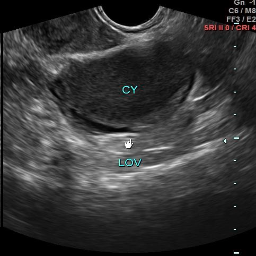

In [ ]:
import random
img_num = random.randint(0, images_np.shape[0]-1)
example = train_dataset[img_num]
image = example["image"]
image

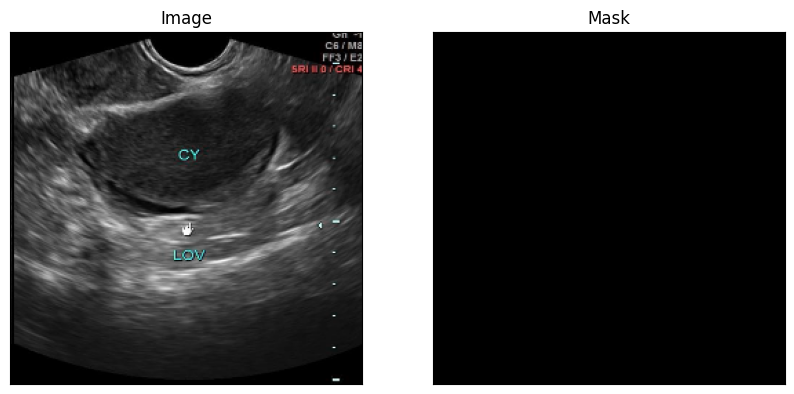

In [ ]:
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 255.5, 255.5, -0.5)

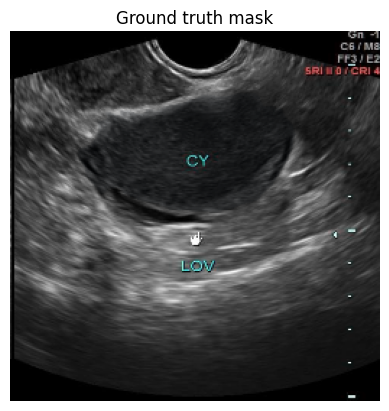

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 2])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Vẽ bounding boxes cho mặt nạ

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Training Model

## Tạo 1 dataset input images and mask

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt | vẽ box cho mặt nạ
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model | Chuẩn bị mặt nạ và hộp giới hạn
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default | Loại bỏ chiều Batch được thêm vào mặc định
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation | Thêm ground truth để đánh giá việc Segment sau này, đánh giá hiệu suất mô hình
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

## Load model SAM

### Xử lý dữ liệu để tương thích với đầu vào Model

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataseta
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [ ]:
example = val_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load model Pretrained của Segment Anything

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

### Khởi tạo model với hàm tối ưu là Adam, hàm loss là DiceCELoss

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

### Train Model

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/3 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint nếu chưa tồn tại
checkpoint_dir = '/content/drive/MyDrive/DATN/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))

    # Tính loss trung bình của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)

    # In thông tin về epoch và loss
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {epoch_loss_mean}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if epoch_loss_mean < best_loss:
        # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = epoch_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, '/content/drive/MyDrive/DATN/best_checkpoint_SAM/best_model_weights.pt'))
        print("Best model weights saved.")


100%|██████████| 3/3 [03:36<00:00, 72.13s/it]


EPOCH: 0
Mean loss: 0.9160422086715698
Best model weights saved.


100%|██████████| 3/3 [03:24<00:00, 68.21s/it]


EPOCH: 1
Mean loss: 0.7734914223353068
Best model weights saved.


100%|██████████| 3/3 [03:35<00:00, 71.96s/it]


EPOCH: 2
Mean loss: 0.751518964767456
Best model weights saved.


100%|██████████| 3/3 [03:38<00:00, 72.99s/it]


EPOCH: 3
Mean loss: 0.6807768146197001
Best model weights saved.


100%|██████████| 3/3 [03:22<00:00, 67.66s/it]


EPOCH: 4
Mean loss: 0.6469164888064066
Best model weights saved.


### Early Stopping

In [ ]:
import numpy as np

# Khởi tạo biến để theo dõi hiệu suất trên tập kiểm tra
best_val_loss = float('inf')
patience = 10
counter = 0

# Training loop
for epoch in range(num_epochs):
    # Code huấn luyện mô hình ở đây...

    # Đánh giá hiệu suất trên tập kiểm tra
    val_losses = []
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            # forward pass và tính loss trên tập kiểm tra
            val_outputs = model(batch["pixel_values"].to(device),
                                batch["input_boxes"].to(device),
                                multimask_output=False)
            val_predicted_masks = val_outputs.pred_masks.squeeze(1)
            val_ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(val_predicted_masks, val_ground_truth_masks.unsqueeze(1))
            val_losses.append(val_loss.item())

    # Tính loss trung bình trên tập kiểm tra
    mean_val_loss = np.mean(val_losses)

    # In thông tin về epoch và loss trên tập kiểm tra
    print(f'EPOCH: {epoch}')
    print(f'Validation Mean loss: {mean_val_loss}')

    # Kiểm tra xem hiệu suất trên tập kiểm tra có cải thiện không
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        counter = 0
        # Lưu trọng số tốt nhất
        torch.save(model.state_dict(), 'best_model_weights.pt')
    else:
        # Nếu không cải thiện, tăng biến đếm
        counter += 1
        # Nếu đếm vượt quá số lần kiên nhẫn, dừng lại
        if counter >= patience:
            print("Early stopping...")
            break


In [ ]:
 # Save the model's state dictionary to a file
torch.save(model.state_dict(), "checkpoint.pth")

### Load hàm loss đánh giá model

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Define functions for calculating evaluation metrics
def dice_coefficient(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    return (2. * intersection + 1) / (union + 1)  # Smoothing to avoid division by zero

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    return (intersection + 1) / (union + 1)  # Smoothing to avoid division by zero

def recall(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    return true_positive / (true_positive + false_negative + 1)  # Smoothing to avoid division by zero

def precision(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted) - true_positive
    return true_positive / (true_positive + false_positive + 1)  # Smoothing to avoid division by zero

### Đánh giá trọng số mô hình với tập Validation Dataset (IOU, Precision, Recall, Dice)

In [ ]:
# Tải trọng số từ checkpoint
checkpoint_path = "checkpoint.pth"
checkpoint = torch.load(checkpoint_path)

# Load trọng số vào mô hình
model.load_state_dict(checkpoint)

# Đặt mô hình vào chế độ đánh giá
model.eval()

# Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
val_dice_scores = []
val_iou_scores = []
val_recall_scores = []
val_precision_scores = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute evaluation metrics
        predicted_masks = torch.sigmoid(outputs['pred_masks'].squeeze(1)) > 0.5
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        val_dice_scores.append(dice_coefficient(predicted_masks, ground_truth_masks))
        val_iou_scores.append(iou(predicted_masks, ground_truth_masks))
        val_recall_scores.append(recall(predicted_masks, ground_truth_masks))
        val_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# Print evaluation metrics
print("\n")
print(f'Validation Dice: {torch.tensor(val_dice_scores).mean()}')
print(f'Validation IOU: {torch.tensor(val_iou_scores).mean()}')
print(f'Validation Recall: {torch.tensor(val_recall_scores).mean()}')
print(f'Validation Precision: {torch.tensor(val_precision_scores).mean()}')


100%|██████████| 2/2 [02:39<00:00, 79.58s/it]

Validation Dice: 0.006304628681391478
Validation IOU: 0.003405989846214652
Validation Recall: 0.0029888679273426533
Validation Precision: 0.13681916892528534


In [ ]:
 # Save the model's state dictionary to a file | Lưu model
torch.save(model.state_dict(), "/content/drive/MyDrive/DATN/weight/checkpoint_22_3.pkl")

### Train tiếp model từ trọng số

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DATN/weight/checkpoint_10.pth"))

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

#Kiểm thử mô hình

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("checkpoint.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images_np.shape[0]-1)

# load image
test_image = test_dataset[0]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_dataset[0]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


ValueError: too many values to unpack (expected 2)

#Inference

In [ ]:

import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = dataset[0]["image"]
image

NameError: name 'dataset' is not defined

In [ ]:

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[0]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 3])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [ ]:
import torch.nn.functional as F
from typing import Tuple
from torch.nn import MSELoss

loss_fn = MSELoss()

def postprocess_masks(masks: torch.Tensor, input_size: Tuple[int, ...], original_size: Tuple[int, ...], image_size=1024) -> torch.Tensor:
    """
    Remove padding and upscale masks to the original image size.

    Args:
      masks (torch.Tensor):
        Batched masks from the mask_decoder, in BxCxHxW format.
      input_size (tuple(int, int)):
        The size of the image input to the model, in (H, W) format. Used to remove padding.
      original_size (tuple(int, int)):
        The original size of the image before resizing for input to the model, in (H, W) format.

    Returns:
      (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
        is given by original_size.
    """
    masks = F.interpolate(
        masks,
        (image_size, image_size),
        mode="bilinear",
        align_corners=False,
    )
    masks = masks[..., : input_size[0], : input_size[1]]
    masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
    return masks